In [1]:
# import sys
# sys.path.insert(1, "/Users/ischoning/PycharmProjects/eyeMovements/eventdetect-master")
import pandas as pd
from pylab import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import matplotlib.transforms as mtransforms
import viterbi
import baum_welch
from scipy.interpolate import make_interp_spline, BSpline


def show_path(x, y, targetx, targety):
    fig, ax = plt.subplots(1,1)
    ax.scatter(x, y, s = 0.5, label='participant')
    ax.scatter(targetx, targety, s = 10, c = 'orange', label = 'target')
    ax.set_title('Angular Visual Movement')
    ax.set_xlabel('degrees')
    ax.set_ylabel('degrees')
    ax.legend()
    fig.show()

    return None

def plot_eye_path(df):
    '''
    input: pandas dataframe that includes 'Left(Right)EyeForward_x(y)' in header
    output: two scatter plots (x,y movements of each eye)
    return: None
    '''
    fig, ax = plt.subplots(1,2, sharex = True, sharey = True)

    ax[0].scatter(x=df['Ax_left'], y=df['Ay_left'])
    ax[0].set_title('Left Eye Displacement')

    ax[1].scatter(x=df['Ax_right'], y=df['Ay_right'])
    ax[1].set_title('Right Eye Displacement')

    plt.xlabel('degrees')
    plt.ylabel('degrees')

    plt.show()

    return None

def plot_vs_time(t, x, y = [], title = None, x_axis = None, y_axis = None, x_label = None, y_label = None, event = None):
    '''
    input: two values (x,y) to be plotted against time
    return: None
    '''
    if y_label is None:
        y_label = 'y'
    if x_label is None:
        x_label = 'x'
    if x_axis is None:
        x_axis = 'timestamp (ms)'

    fig, ax = plt.subplots()

    if len(y) == 0:
        ax.plot(t, x, color = 'red')

        # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
        if event is not None:
            trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
            min_val = min(x)
            max_val = max(x)
            ax.fill_between(t, min_val, max_val, where = event == 1,
                            facecolor='green', alpha=0.5, transform=trans, label='fixation')
            ax.fill_between(t, min_val, max_val, where = event == 0,
                            facecolor='red', alpha=0.5, transform=trans, label='saccade')
            ax.legend()
    else:
        ax.plot(t, x, color = 'r', label = x_label)
        ax.plot(t, y, color = 'b', label = y_label)
        ax.legend()

    ax.set_title(title)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)

    plt.show()

    return None


def make_hist(data, title, x_axis, y_axis, density = False):
    if density:
        result, bin_edges = np.histogram(data, bins=len(data), density = True)
        plt.hist(data, bins=len(data), density = True)
    else:
        plt.hist(data, bins=int(len(data)/2))
    plt.title(title)
    plt.ylabel(y_axis)
    plt.xlabel(x_axis)
    plt.show()

    if density:
        return result, bin_edges
    else: return None

def pmf(data, title, x_axis, y_axis):
    hist, bin_edges = make_hist(data, title, x_axis, y_axis, density = True)
    #print("hist sum:", np.sum(hist * np.diff(bin_edges))) # sanity check - should = 1

    return None


def label_event(event, states):
    if len(states) == 0:
        print("No states provided.")
        return
    if event == 1:
        return states[1] # 'Fixation'
    if event == 0:
        return states[0] # 'Saccade'
    return 'Other'

def print_events(t, event, states):
    events = []
    event_label = label_event(event.iloc[0], states)
    start = t.iloc[0]
    n = 1
    event_change = False
    for i in range(len(event)):
        if i == len(event)-1 or event.iloc[i] != event.iloc[i+1]:
            event_change = True
        if event_change:
            end = t.iloc[i]
            events.append([event_label, n, start, end])
            if i != len(event)-1:
                start = t.iloc[i+1]
                event_label = label_event(event.iloc[i+1], states)
                n = 1
                event_change = False
        else:
            n += 1

    print('=====================================================================')

    for e in events:
        print("%s for %d samples from %d ms to %d ms." % (e[0], e[1], e[2], e[3]))

    print('=====================================================================')

    print('Number of Fixation events:', sum(event==1))
    print('Number of Saccade events:', sum(event==0))
    print('Total number of events:', len(event))

    return None

def dict_to_list(d):
    '''
    :param d: dictionary
    :return: list of values in dictionary
    '''
    dictlist = []
    for value in d.values():
        dictlist.append(value)
    return dictlist

def gaussian(mu, sigma, x):
    return 1.0/sqrt(2*pi*sigma**2)*exp(-(x-mu)**2/(2*sigma**2))

def normalize(d):
    '''
    input: dictionary
    returns: normalized dictionary (sum of values = 1)
    '''
    #total = sum(d.values()) # sum not working...
    dictlist = dict_to_list(d)
    total = sum(dictlist)
    d = {k: v / total for k, v in d.items()}
    return d

def overview_plot(data):
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.75)

    ax1 = ax.twinx()
    ax2 = ax.twinx()

    # Offset the right spine of twin2.  The ticks and label have already been
    # placed on the right by twinx above.
    #ax2.spines.right.set_position(("axes", 1.2))

    p1, = ax.plot(data.sample_i, data.position, "b-", label="Displacement")
    p2, = ax1.plot(data.sample_i, data.velocity, "r-", label="Velocity")
    p3, = ax2.plot(data.sample_i, data.acceleration, "g-", label="Acceleration")

    # ax.set_xlim(0, 2)
    # ax.set_ylim(0, 2)
    # ax1.set_ylim(0, 4)
    # ax2.set_ylim(1, 65)

    ax.set_xlabel("sample sequential number")
    ax.set_ylabel("Degree")
    ax1.set_ylabel("Deg/Ms")
    ax2.set_ylabel("Deg/Ms^2")

    ax.yaxis.label.set_color(p1.get_color())
    ax1.yaxis.label.set_color(p2.get_color())
    ax2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    ax1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    ax2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    ax.tick_params(axis='x', **tkw)

    ax.legend(handles=[p1, p2, p3])

    plt.show()

13086
#subject_id                   int64
display_refresh_rate          int64
eyetracker_model             object
dot_deg_sz                  float64
eyetracker_sampling_rate    float64
eyetracker_mode              object
fix_stim_center_size_pix      int64
operator                     object
et_model                     object
display_width_pix             int64
display_height_pix            int64
exp_date                     object
screen_width                float64
screen_height               float64
eye_distance                float64
SESSION_ID                    int64
trial_id                      int64
TRIAL_START                 float64
TRIAL_END                   float64
posx                        float64
posy                        float64
dt                          float64
ROW_INDEX                     int64
BLOCK                        object
session_id                    int64
device_time                 float64
time                        float64
left_gaze_x           

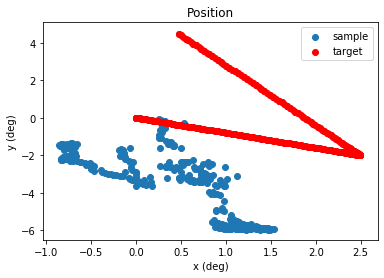

In [2]:
# files
file = '/Users/ischoning/PycharmProjects/GitHub/data/varjo_events_3_0_0.txt'

# create dataframe
df = pd.read_csv(file, sep="\t")

print(len(df))
# print(df.columns.values)
print(df.dtypes)
print(df.head())

df = df[:500]

plt.scatter(df.right_angle_x, df.right_angle_y, label = 'sample')
plt.scatter(df.target_angle_x, df.target_angle_y, color = 'red', label = 'target')
plt.title('Position')
plt.xlabel('x (deg)')
plt.ylabel('y (deg)')
plt.legend()
plt.show()

In [3]:
del_x = np.diff(df.right_angle_x, prepend=0)
del_y = np.diff(df.right_angle_y, prepend=0)
df['d'] = np.sqrt(del_x**2 + del_y**2)
#df['vel'] = df.d/df.dt*1000
avg_sample_rate = np.mean(df.dt)

df['vel'] = np.zeros((len(df),1))
df['accel'] = np.zeros((len(df),1))
df.d[0] = df.vel[0] = df.accel[0] = None
df.vel[len(df)-1] = df.accel[len(df)-1] = None
for i in range(1,len(df)-2):
    df.vel[i] = (del_x[i+1] - del_x[i-1])*avg_sample_rate
    df.accel[i] = ((del_x[i+1] - del_x[i]) - (del_x[i] - del_x[i-1]))*avg_sample_rate**2

# only take the magnitude
df.vel = np.abs(df.vel)
df.accel = np.abs(df.accel)

print("Number of datapoints with intersample velocity greater than 1000 deg/ms:", np.sum(np.where(df.vel > 1000)))
df.drop(df[df.vel > 1000].index, inplace = True)
df.reset_index(drop=True, inplace=True)

#df = df.iloc[1:]

Number of datapoints with intersample velocity greater than 1000 deg/ms: 899


/opt/miniconda3/envs/visaid/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/miniconda3/envs/visaid/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/miniconda3/envs/visaid/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

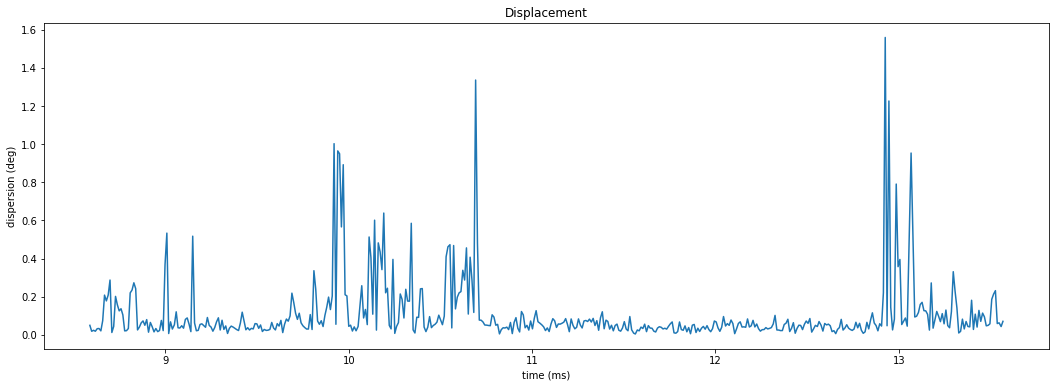

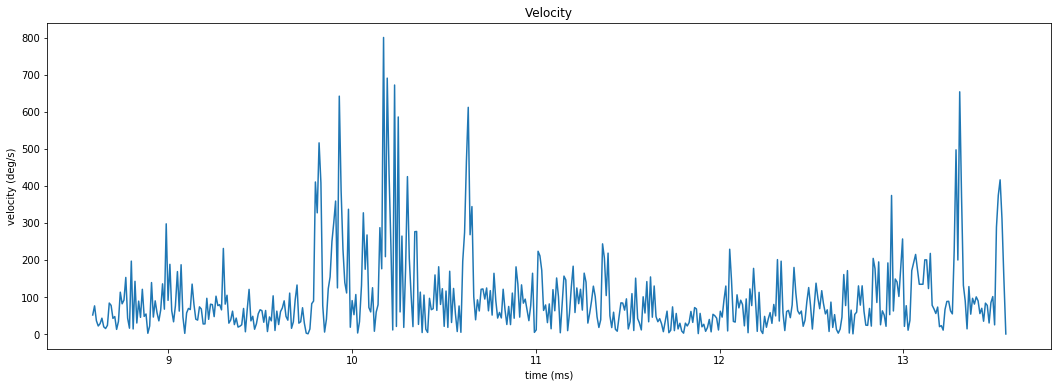

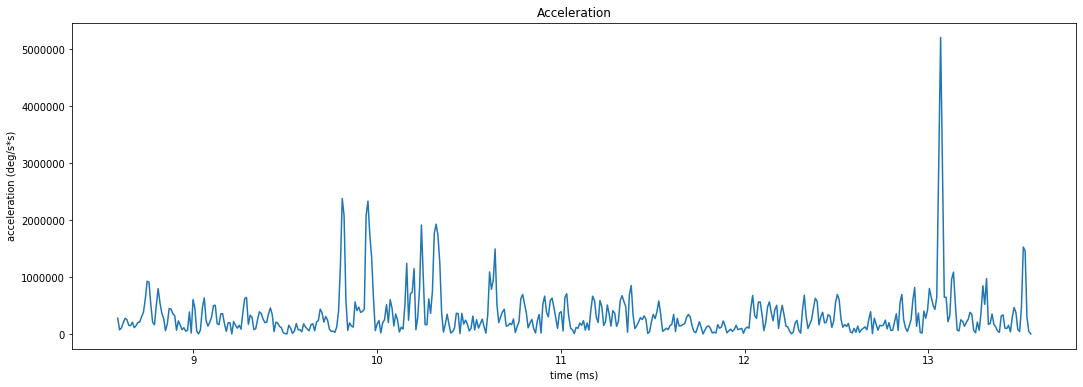

In [4]:
plt.figure(figsize=(18, 6)) # In Matplotlib all the diagrams are created at a default size of 6.4 x 4.8 inches.
plt.plot(df.time, df.d)
plt.title('Displacement')
plt.xlabel('time (ms)')
plt.ylabel('dispersion (deg)')
plt.show()

plt.figure(figsize=(18, 6)) # In Matplotlib all the diagrams are created at a default size of 6.4 x 4.8 inches.
plt.plot(df.time, df.vel)
plt.title('Velocity')
plt.xlabel('time (ms)')
plt.ylabel('velocity (deg/s)')
plt.show()

plt.figure(figsize=(18, 6)) # In Matplotlib all the diagrams are created at a default size of 6.4 x 4.8 inches.
plt.plot(df.time, df.accel)
plt.title('Acceleration')
plt.xlabel('time (ms)')
plt.ylabel('acceleration (deg/s*s)')
plt.show()

/opt/miniconda3/envs/visaid/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/miniconda3/envs/visaid/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


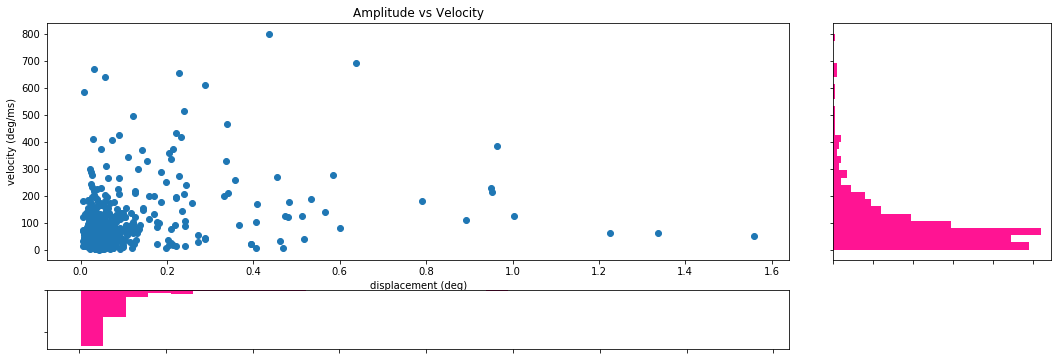

In [5]:
fig = plt.figure(figsize=(18, 6)) # In Matplotlib all the diagrams are created at a default size of 6.4 x 4.8 inches.
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# Scatterplot on main ax
ax_main.scatter(df.d, df.vel)

# histogram on the right
ax_bottom.hist(df.d, 30, histtype='stepfilled', orientation='vertical', color='deeppink')
ax_bottom.invert_yaxis()

# histogram in the bottom
ax_right.hist(df.vel, 30, histtype='stepfilled', orientation='horizontal', color='deeppink')

ax_main.set(title='Amplitude vs Velocity', xlabel ='displacement (deg)', ylabel ='velocity (deg/ms)')
plt.show()

TypeError: imshow() got multiple values for argument 'cmap'